In [1]:
import math
import sys
import matplotlib.pyplot as plt

import boto3
import numpy as np

sys.path.append('../')
sys.path.append('../../')
from run_utils import get_env_dataset, run_env_experiment, plot_ratings_mses
from run_utils import s3_experiment_dir_name, plot_ratings_mses_s3, s3_load_trial
from reclab.environments import Topics, LatentFactorBehavior
from env_defaults import *
from reclab.recommenders import TopPop

%matplotlib notebook


/home/ec2-user/recsys-eval/experiments/run_utils.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook
/home/ec2-user/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of 

<IPython.core.display.Javascript object>


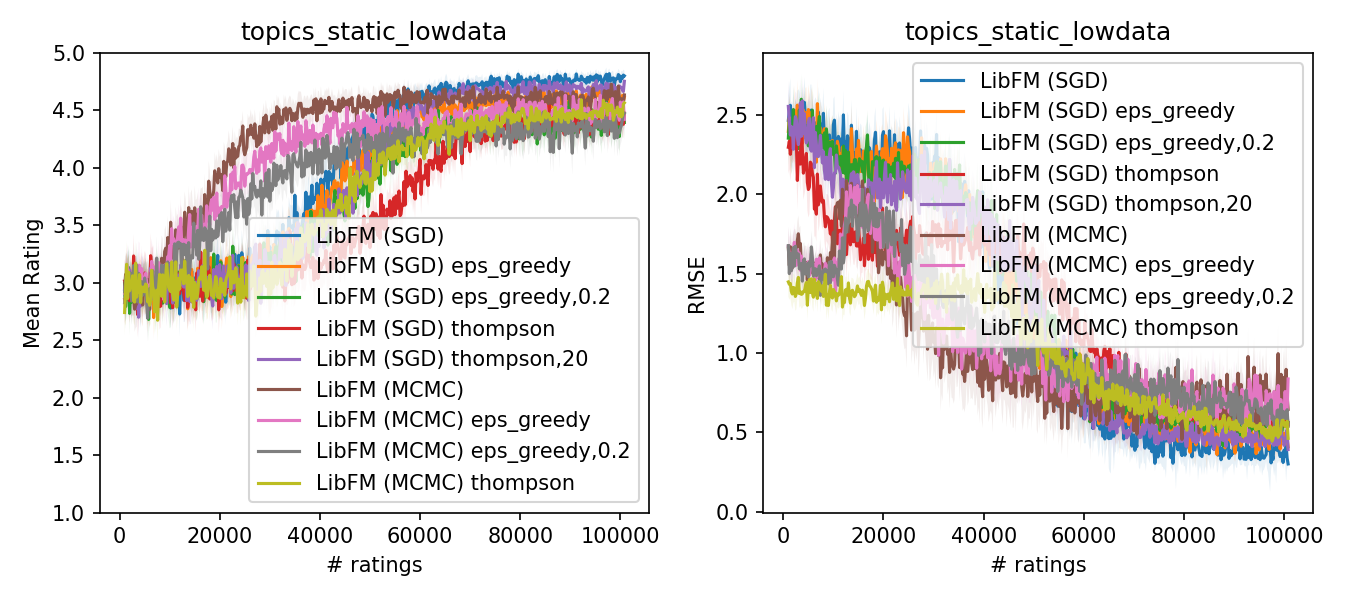

<IPython.core.display.Javascript object>


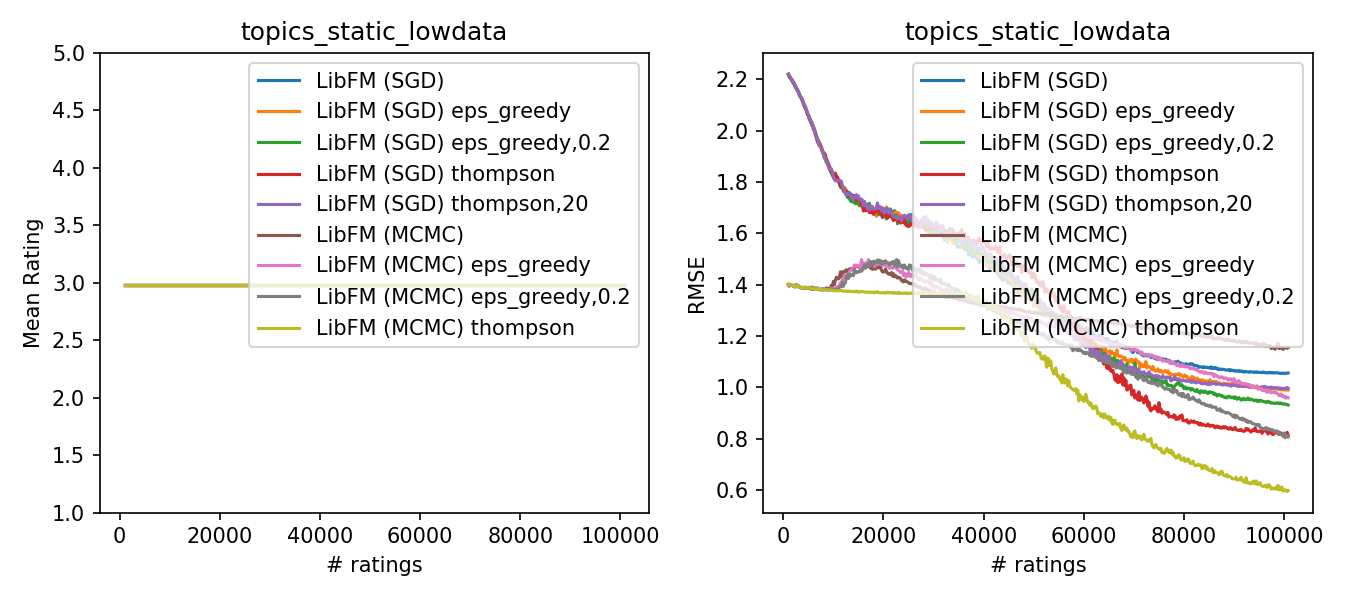

<IPython.core.display.Javascript object>


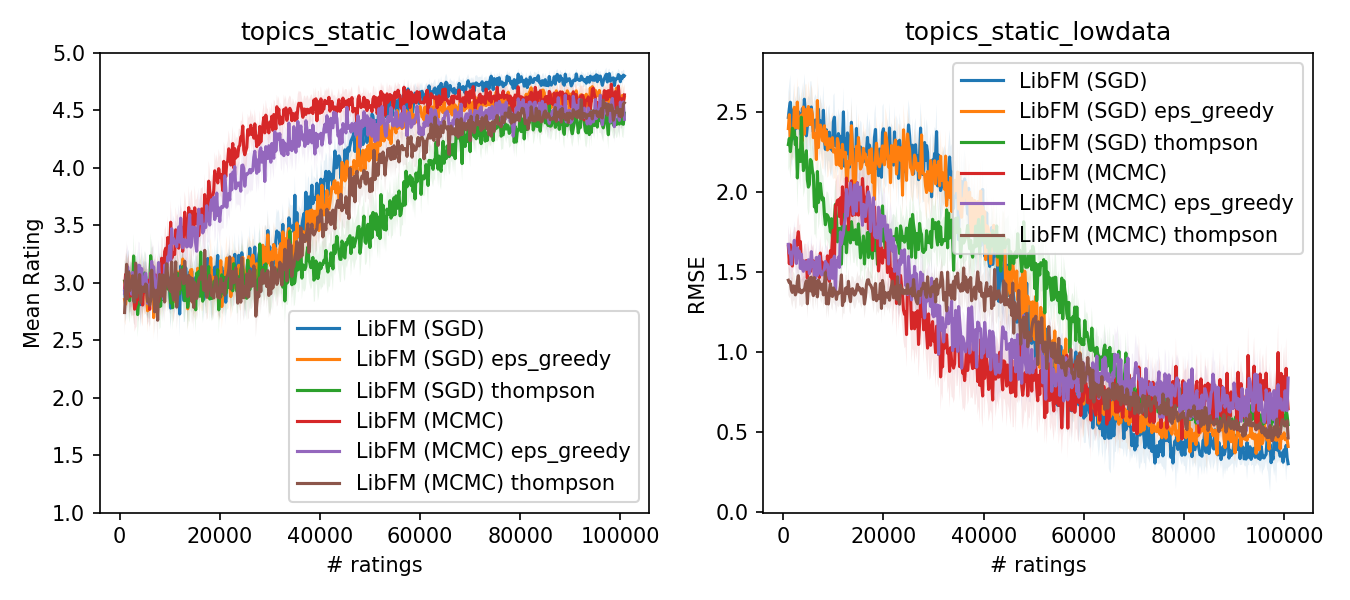

{'LibFM (SGD)': (array([[2.92419451, 2.84649858, 2.91388403, 3.07443723, 3.09987279,
          2.89902366, 3.00330843, 2.9782175 , 3.01019926, 2.90168598,
          2.92119594, 2.93603654, 3.01047244, 3.09327907, 2.84580356,
          2.96589022, 2.80991196, 2.89770503, 3.06697236, 2.94653754,
          2.99322363, 2.98593012, 2.89757574, 2.89515109, 2.96345239,
          3.00787645, 2.97453462, 2.95185556, 2.97106269, 2.97771339,
          2.8743365 , 3.01662099, 2.97004031, 2.9752275 , 3.0097962 ,
          2.85938281, 3.01464432, 3.10369134, 2.94254383, 3.05923263,
          2.94394085, 3.0391547 , 3.08886062, 3.05459831, 3.03789987,
          2.94556519, 2.77944912, 2.98918613, 2.94245241, 2.96747519,
          2.92282686, 2.97341396, 2.95988707, 3.05215243, 2.96360774,
          2.72821575, 3.14636733, 2.93408431, 3.05952176, 2.84799537,
          2.85134437, 3.13124341, 2.99853955, 2.80787666, 3.00506518,
          3.09501432, 2.97059585, 3.10138203, 2.8314023 , 3.02459153,
     

In [6]:
# S3 storage parameters
bucket_name = 'recsys-eval'
data_dir = 'Sarah'

full_recommender_names = ['LibFM (SGD)', 'LibFM (SGD) eps_greedy', 'LibFM (SGD) eps_greedy,0.2', 
                          'LibFM (SGD) thompson', 'LibFM (SGD) thompson,20',
                          'LibFM (MCMC)', 'LibFM (MCMC) eps_greedy', 'LibFM (MCMC) eps_greedy,0.2',
                          'LibFM (MCMC) thompson'] #, 'LibFM (MCMC) thompson,20'] 

recommender_names = ['LibFM (SGD)', 'LibFM (SGD) eps_greedy', 'LibFM (SGD) thompson',
                     'LibFM (MCMC)', 'LibFM (MCMC) eps_greedy', #'LibFM (MCMC) eps_greedy,0.2',
                     'LibFM (MCMC) thompson'] #, 'LibFM (MCMC) thompson,20'] #, 'LibFM (MCMC) thompson']


# recommender_names = ['LibFM (SGD) eps_greedy', 'LibFM (SGD) thompson', 
#                      'LibFM (MCMC) eps_greedy', 'LibFM (MCMC) thompson'] #, 'LibFM (MCMC) thompson']


ENV_PARAMS =TOPICS_STATIC
env_name = ENV_PARAMS['name'] + '_lowdata'

# Experiment setup.
n_trials = 1
trial_seeds = [i for i in range(n_trials)]
num_init_ratings = ENV_PARAMS['optional_params']['num_init_ratings'] - 99000
len_trial = get_len_trial(ENV_PARAMS)
num_users, _ = get_num_users_items(ENV_PARAMS)


all_stats = plot_ratings_mses_s3(full_recommender_names,
                     len_trial,
                     bucket_name,
                     data_dir,
                     env_name,
                     trial_seeds,
                     plot_dense=False,
                     num_users=num_users,
                     num_init_ratings=num_init_ratings,
                     rating_frequency = ENV_PARAMS['optional_params']['rating_frequency'],
                     threshold=10,
                     title=[env_name, env_name])

all_stats_dense = plot_ratings_mses_s3(full_recommender_names,
                     len_trial,
                     bucket_name,
                     data_dir,
                     env_name,
                     trial_seeds,
                     plot_dense=True,
                     num_users=num_users,
                     num_init_ratings=num_init_ratings,
                     rating_frequency = ENV_PARAMS['optional_params']['rating_frequency'],
                     threshold=10,
                     title=[env_name, env_name])

plot_ratings_mses_s3(recommender_names,
                     len_trial,
                     bucket_name,
                     data_dir,
                     env_name,
                     trial_seeds,
                     plot_dense=False,
                     num_users=num_users,
                     num_init_ratings=num_init_ratings,
                     rating_frequency = ENV_PARAMS['optional_params']['rating_frequency'],
                     threshold=10,
                     title=[env_name, env_name])


In [7]:
cutoff = int(1000 / (ENV_PARAMS['optional_params']['rating_frequency'] * num_users)) # 1000 ratings
all_means = {}
all_rmses = {}
for label in all_stats.keys():
    means, lower_bounds, upper_bounds = all_stats[label]
    means = means[0]
    lower_bounds = lower_bounds[0]
    upper_bounds = upper_bounds[0]
    
    all_means[label] = (np.mean(means[:cutoff]), np.mean(means[-cutoff:]))
    
    means, lower_bounds, upper_bounds = all_stats[label]
    mse = means[1]
    lower_bounds = lower_bounds[1]
    upper_bounds = upper_bounds[1]
    # Transform the MSE into the RMSE and correct the associated intervals.
    rmse = np.sqrt(mse)
    lower_bounds = np.sqrt(lower_bounds)
    upper_bounds = np.sqrt(upper_bounds)
        
    all_rmses[label] = (np.mean(rmse[:cutoff]), np.mean(rmse[-cutoff:]))


In [9]:
dense_rmses = {}
for label in all_stats.keys():
    means, lower_bounds, upper_bounds = all_stats_dense[label]
    mse = means[1]
    lower_bounds = lower_bounds[1]
    upper_bounds = upper_bounds[1]
    # Transform the MSE into the RMSE and correct the associated intervals.
    rmse = np.sqrt(mse)
    lower_bounds = np.sqrt(lower_bounds)
    upper_bounds = np.sqrt(upper_bounds)
        
    dense_rmses[label] = (np.mean(rmse[:cutoff]), np.mean(rmse[-cutoff:]))


In [33]:
labels

dict_keys(['LibFM (SGD)', 'LibFM (SGD) eps_greedy', 'LibFM (SGD) eps_greedy,0.2', 'LibFM (SGD) thompson', 'LibFM (SGD) thompson,20', 'LibFM (MCMC)', 'LibFM (MCMC) eps_greedy', 'LibFM (MCMC) eps_greedy,0.2', 'LibFM (MCMC) thompson'])

In [62]:
ticks

[3, 2, 1, 0]

<IPython.core.display.Javascript object>


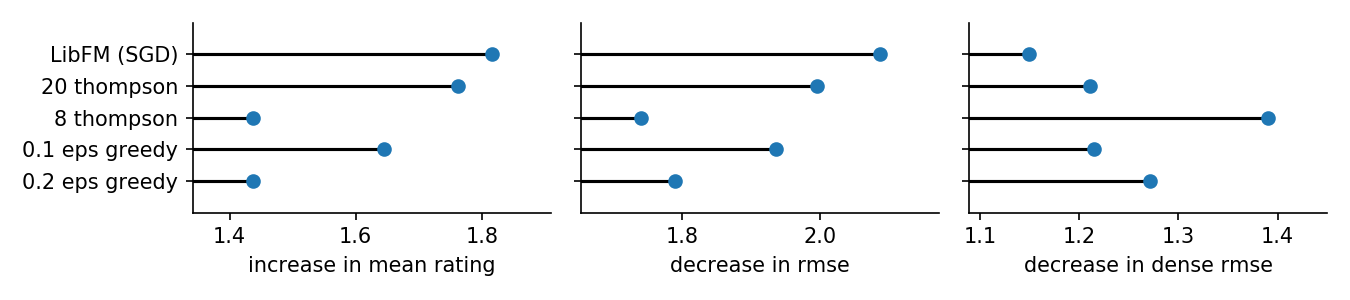

<IPython.core.display.Javascript object>


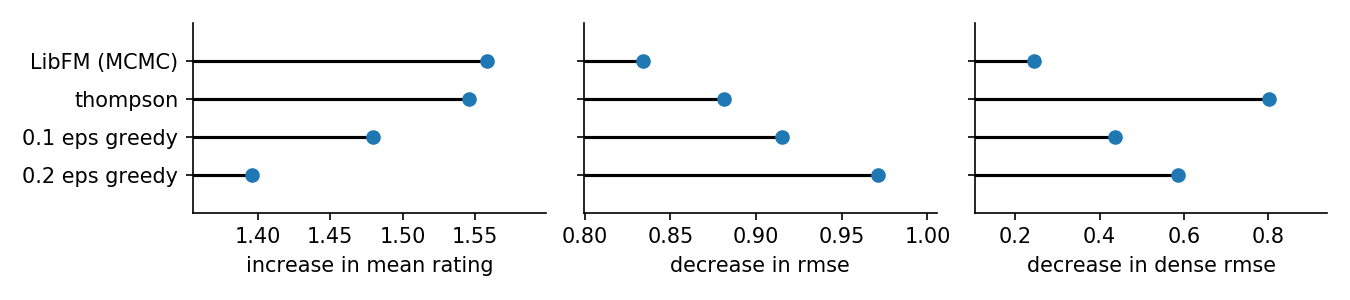

In [64]:
labels = all_stats.keys()

# width=0.8
# num_sgd = 5; num_mcms = 4

# label_lists = [[label for label in labels if 'SGD' in label], [label for label in labels if 'MCMC' in label]]
label_lists = [['LibFM (SGD)', 'LibFM (SGD) thompson,20', 'LibFM (SGD) thompson',  'LibFM (SGD) eps_greedy', 'LibFM (SGD) eps_greedy,0.2'],
               ['LibFM (MCMC)', 'LibFM (MCMC) thompson', 'LibFM (MCMC) eps_greedy', 'LibFM (MCMC) eps_greedy,0.2']]

abbrev = {'LibFM (SGD)':'LibFM (SGD)', 'LibFM (SGD) eps_greedy':'0.1 eps greedy',
          'LibFM (SGD) eps_greedy,0.2':'0.2 eps greedy','LibFM (SGD) thompson':'8 thompson',
           'LibFM (SGD) thompson,20':'20 thompson','LibFM (MCMC)':'LibFM (MCMC)',
           'LibFM (MCMC) eps_greedy':'0.1 eps greedy', 'LibFM (MCMC) eps_greedy,0.2':'0.2 eps greedy', 
          'LibFM (MCMC) thompson':'thompson'}
label_lists_abbrev = [[abbrev[label] for label in label_list] for label_list in label_lists]

for label_list, label_list_abbrev in zip(label_lists, label_lists_abbrev):
    
    plt.figure(figsize=[9,2])

    ax = plt.subplot(1,3,1)
    ax.spines['top'].set_visible(False);ax.spines['right'].set_visible(False)
    
    heights = [all_means[label][1]-all_means[label][0] for label in label_list]
#     heights = [all_means[label][1] for label in label_list]



    ticks = list(reversed(np.arange(len(label_list))))
    # plt.bar(ticks, heights, width=width)

    plt.hlines(y=ticks,xmin=0,xmax=heights)
    plt.plot(heights, ticks, "o")
    plt.yticks(ticks, label_list_abbrev)
    plt.xlabel('increase in mean rating')
    extent = [np.min(heights), np.max(heights)]
    xrange = [extent[0] - 0.25*np.diff(extent), extent[1] + 0.25*np.diff(extent)]
    plt.xlim(xrange); plt.ylim([-1, len(label_list)])
    # ax.set_xticks(ticks)
    # ax.set_xticklabels(labels, rotation=90)

    ax = plt.subplot(1,3,2)
    ax.spines['top'].set_visible(False);ax.spines['right'].set_visible(False)
    heights2 = [all_rmses[label][0]-all_rmses[label][1] for label in label_list]
#     heights2 = [all_rmses[label][0] for label in label_list]

    plt.hlines(y=ticks,xmin=0,xmax=heights2)
    plt.plot(heights2, ticks, "o")
    plt.yticks(ticks, []) #, labels)
    plt.xlabel('decrease in rmse')
    extent = [np.min(heights2), np.max(heights2)]
    xrange = [extent[0] - 0.25*np.diff(extent), extent[1] + 0.25*np.diff(extent)]
    plt.xlim(xrange)
    plt.ylim([-1, len(label_list)])
    # plt.bar(ticks, heights2, width=width)
    # plt.title('decrease in rmse')
    # ax.set_xticks(ticks)
    # ax.set_xticklabels(labels, rotation=90)


    ax = plt.subplot(1,3,3)
    ax.spines['top'].set_visible(False);ax.spines['right'].set_visible(False)
    heights3 = [dense_rmses[label][0]-dense_rmses[label][1] for label in label_list]
#     heights3 = [dense_rmses[label][0] for label in label_list]

    plt.hlines(y=ticks,xmin=0,xmax=heights3)
    plt.plot(heights3, ticks, "o")
    plt.yticks(ticks, []) #, labels)
    plt.xlabel('decrease in dense rmse')
    extent = [np.min(heights3), np.max(heights3)]
    xrange = [extent[0] - 0.25*np.diff(extent), extent[1] + 0.25*np.diff(extent)]
    plt.xlim(xrange); plt.ylim([-1, len(label_list)])
    # 
    # plt.figure()
    # plt.bar(range(len(heights)), heights)

    # plt.figure()
    # for label in all_stats.keys():
    #     plt.scatter(all_rmses[label][0], all_rmses[label][1], label=label)
    plt.tight_layout()

<IPython.core.display.Javascript object>


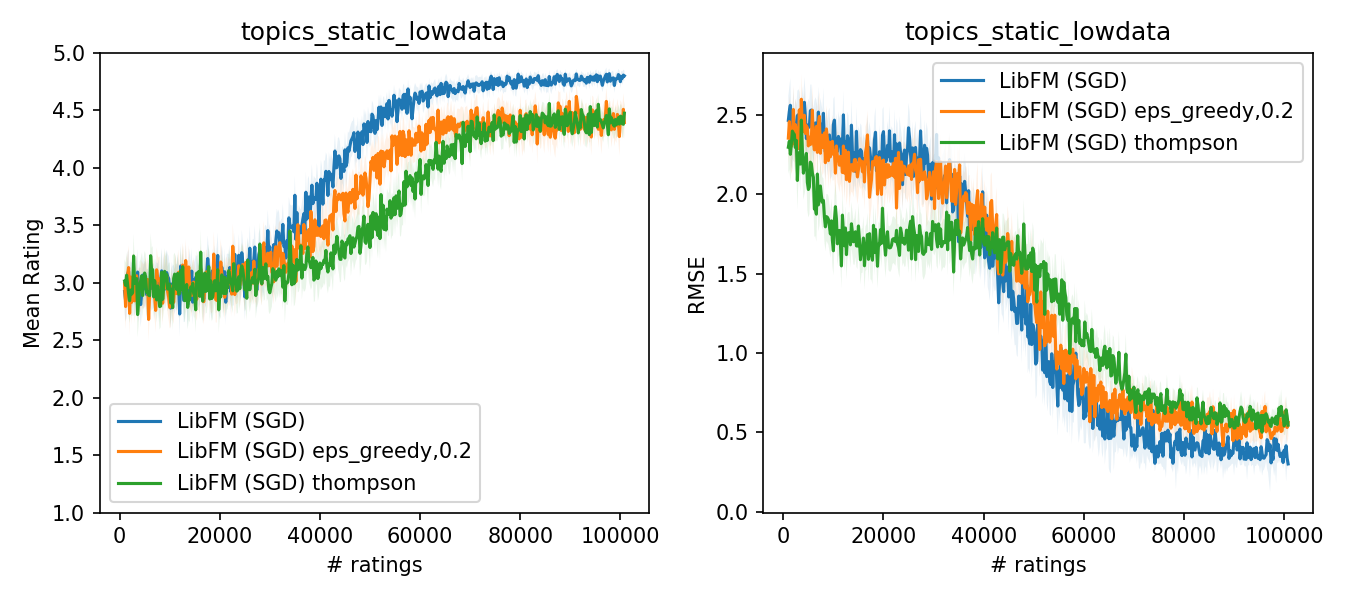

<IPython.core.display.Javascript object>


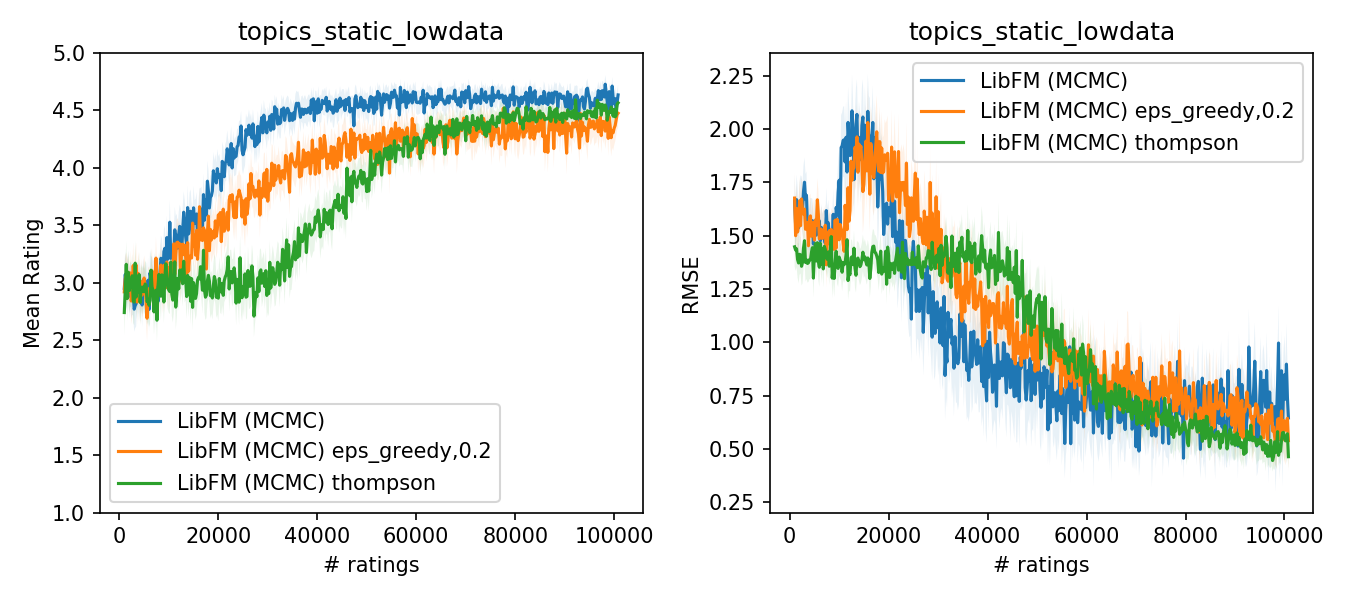

In [67]:
# S3 storage parameters
bucket_name = 'recsys-eval'
data_dir = 'Sarah'


recommender_names_list = [['LibFM (SGD)', 'LibFM (SGD) eps_greedy,0.2', 'LibFM (SGD) thompson'],
                          ['LibFM (MCMC)', 'LibFM (MCMC) eps_greedy,0.2', 'LibFM (MCMC) thompson'] ]


# recommender_names = ['LibFM (SGD) eps_greedy', 'LibFM (SGD) thompson', 
#                      'LibFM (MCMC) eps_greedy', 'LibFM (MCMC) thompson'] #, 'LibFM (MCMC) thompson']


ENV_PARAMS =TOPICS_STATIC
env_name = ENV_PARAMS['name'] + '_lowdata'

# Experiment setup.
n_trials = 1
trial_seeds = [i for i in range(n_trials)]
num_init_ratings = ENV_PARAMS['optional_params']['num_init_ratings'] - 99000
len_trial = get_len_trial(ENV_PARAMS)
num_users, _ = get_num_users_items(ENV_PARAMS)

for recommender_names in recommender_names_list:
    plot_ratings_mses_s3(recommender_names,
                     len_trial,
                     bucket_name,
                     data_dir,
                     env_name,
                     trial_seeds,
                     plot_dense=False,
                     num_users=num_users,
                     num_init_ratings=num_init_ratings,
                     rating_frequency = ENV_PARAMS['optional_params']['rating_frequency'],
                     threshold=10,
                     title=[env_name, env_name])
0;

In [42]:
1700-int((99000/1000))

1601

In [49]:
# artificial parameter to boost the probability of the more likely items
power = np.ceil(np.log(len(predictions)))
power = 20

selection_probs = np.power(predictions/sum(predictions), power)
selection_probs = selection_probs/sum(selection_probs)

In [50]:
power

20

<BarContainer object of 100 artists>

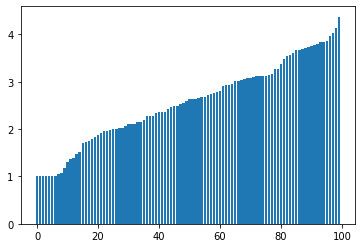

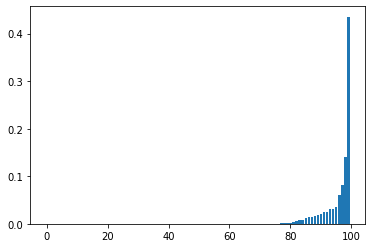

In [51]:
order = np.argsort(predictions)

plt.figure()
plt.bar(range(len(predictions)), predictions[order])

plt.figure()
plt.bar(range(len(selection_probs)), selection_probs[order])

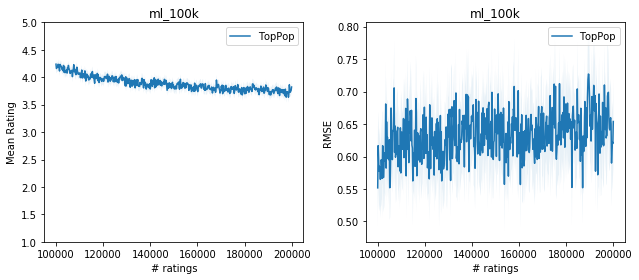

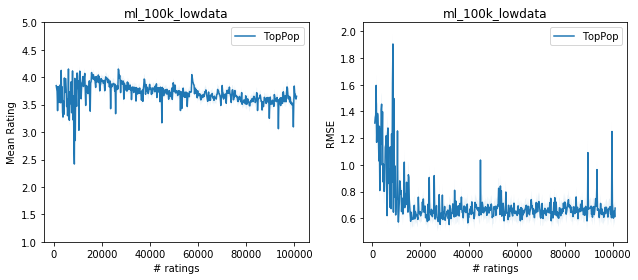

In [5]:
# Below is a model trained with biases (above the model is trained without biases)

In [3]:
num_init_ratings

1000

# Targetted rating investigation

In [36]:
# S3 storage parameters
bucket_name = 'recsys-eval'
data_dir = 'master'

env_name = 'topics_dynamic'
rec_name = 'TopPop'

seed = 0

bucket = boto3.resource('s3').Bucket(bucket_name)
dir_name = s3_experiment_dir_name(data_dir, env_name, rec_name, seed)

res = s3_load_trial(bucket, dir_name, load_dense=True)
rec_hyperparameters, ratings, predictions, dense_ratings, dense_predictions, env_snapshots = res

In [43]:
predictions

array([[3.60831561, 3.60831561, 3.54920085, ..., 3.60831561, 3.60831561,
        3.60831561],
       [3.55393525, 3.55393525, 3.55393525, ..., 3.55393525, 3.55393525,
        3.54988943],
       [3.61663168, 3.61663168, 3.61663168, ..., 3.61663168, 3.61663168,
        3.61663168],
       ...,
       [4.33852062, 3.5442598 , 3.5442598 , ..., 4.33852062, 3.5442598 ,
        4.33852062],
       [3.5869802 , 4.35562549, 3.16229621, ..., 3.5869802 , 4.35562549,
        4.35562549],
       [3.59527462, 3.13271048, 3.59527462, ..., 3.59527462, 3.13271048,
        3.13271048]])

In [42]:
ratings.shape

(500, 200)

In [40]:
env_snapshots[100]._user_preferences

array([[3.39962308, 4.75928017, 3.0360391 , ..., 0.8622031 , 4.60754367,
        4.12411709],
       [4.42783852, 4.86531393, 4.60134838, ..., 3.90484415, 3.3493675 ,
        3.05689221],
       [4.81874039, 3.61465705, 2.21420617, ..., 1.67216156, 1.01210314,
        3.57665274],
       ...,
       [3.48814065, 4.88973791, 0.5611595 , ..., 4.5510338 , 0.75632668,
        2.59087602],
       [3.72606523, 2.29837399, 3.79930549, ..., 0.24544956, 4.46444066,
        1.51739586],
       [2.25980778, 4.66246184, 4.78869622, ..., 2.59515674, 0.65962743,
        4.21208428]])

In [6]:
dense_predictions.shape

(531, 1586126)

In [18]:
ratings = ratings[np.newaxis, np.newaxis, :, :]
predictions = predictions[np.newaxis, np.newaxis, :, :]
dense_ratings = dense_ratings[np.newaxis, np.newaxis, :, :]
dense_predictions = dense_predictions[np.newaxis, np.newaxis, :, :]

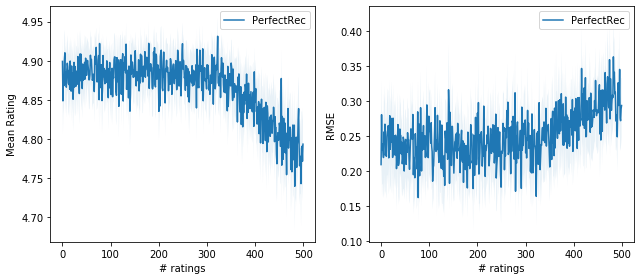

In [28]:
plot_ratings_mses(ratings,
                      np.clip(predictions, 1, 5),
                      [rec_name])

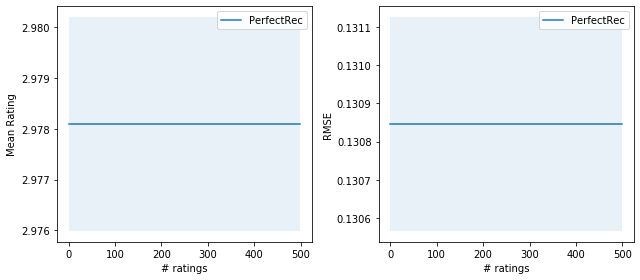

In [21]:
plot_ratings_mses(dense_ratings,
                      dense_predictions,
                      [rec_name])

(array([89524500., 87268000., 84615500., 83790000., 86334000., 85959500.,
        80444500., 82568000., 83908000., 85588000.]),
 array([0.50036225, 1.000315  , 1.50026775, 2.0002205 , 2.50017325,
        3.000126  , 3.50007875, 4.00003151, 4.49998426, 4.99993701,
        5.49988976]),
 <a list of 10 Patch objects>)

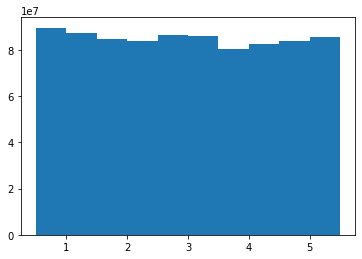

In [23]:
plt.figure()
plt.hist(dense_predictions.flatten())

(array([   58.,   176.,   461.,   793.,  2404.,  3884.,  7128., 14782.,
        26378., 43936.]),
 array([3.7026507 , 3.88237461, 4.06209852, 4.24182242, 4.42154633,
        4.60127023, 4.78099414, 4.96071804, 5.14044195, 5.32016585,
        5.49988976]),
 <a list of 10 Patch objects>)

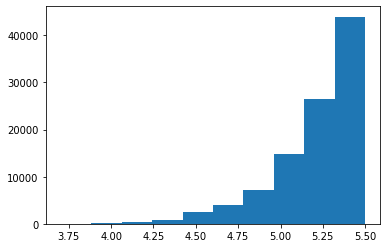

In [24]:
plt.figure()
plt.hist(predictions.flatten())

(array([1.0000e+00, 6.0000e+00, 1.5000e+01, 7.4000e+01, 2.9200e+02,
        8.2400e+02, 2.2500e+03, 5.1770e+03, 9.8550e+03, 8.1506e+04]),
 array([2.18677833, 2.46810049, 2.74942266, 3.03074483, 3.312067  ,
        3.59338916, 3.87471133, 4.1560335 , 4.43735567, 4.71867783,
        5.        ]),
 <a list of 10 Patch objects>)

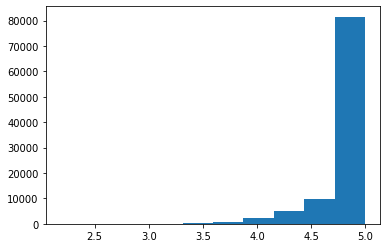

In [25]:
plt.figure()
plt.hist(ratings.flatten())